Successfully loaded data from E:/data_for_seg/


[15:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


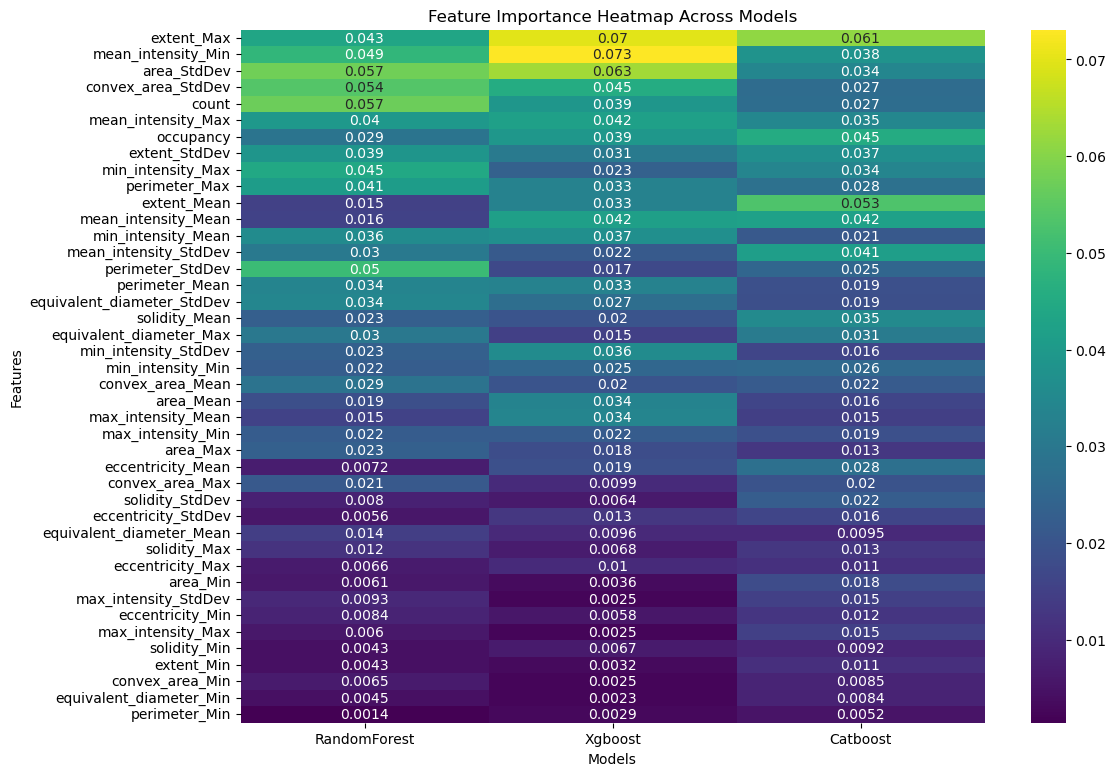

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

random_state = 42

X, y, unique_labels, label_mapping, data = load_data(get_hard_disk_path("Segmentation"))
#visualize_correlation(X)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
ix_training, ix_test = [], []
# Loop through each fold and append the training & test indices to the empty lists above
for fold in kf.split(X, y):
    ix_training.append(fold[0]), ix_test.append(fold[1])
# List to store averaged SHAP values for each fold
average_shap_values_per_fold = []
cumulative_f1_scores = {label: 0 for label in unique_labels}
model_names = ["RandomForest", "Xgboost", "Catboost"]

for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): #-#-#
    X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
    y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix]

# Prepare a matrix to hold the SHAP values for each model
shap_values_matrix = np.zeros((len(X.columns), len(model_names)))

# Train each model and compute SHAP values
for i, model_name in enumerate(model_names):
    classifier = train_model(X_train, y_train, unique_labels, model_name, random_state)
    shap_values = get_shap(classifier, X_test)
    # Average absolute SHAP values for each feature
    # Check if SHAP values are a list (multi-class scenario) and average across classes
    if isinstance(shap_values, list):
        shap_values = np.sum([np.abs(sv) for sv in shap_values], axis=0)
    
    # Normalize SHAP values for each model
    normalized_shap_values = np.abs(shap_values).mean(axis=0)
    normalized_shap_values /= normalized_shap_values.sum()

    # Store normalized SHAP values
    shap_values_matrix[:, i] = normalized_shap_values

# Calculate the sum of SHAP values across all models for each feature
sum_shap_values = shap_values_matrix.sum(axis=1)

# Get the indices of the 10 features with the highest sums
top_10_feature_indices = np.argsort(sum_shap_values)[-10:][::-1]

# Extract the names of the top 10 features
top_10_feature_names = X.columns[top_10_feature_indices]

# Order the features based on the sum of SHAP values
ordered_indices = np.argsort(sum_shap_values)[::-1]
ordered_shap_values_matrix = shap_values_matrix[ordered_indices, :]

# Creating the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(ordered_shap_values_matrix, cmap='viridis', yticklabels=X.columns[ordered_indices], xticklabels=model_names, annot=True)
plt.title("Feature Importance Heatmap Across Models")
plt.ylabel("Features")
plt.xlabel("Models")
plt.show()

In [19]:
print(top_10_feature_names)

Index(['extent_Max', 'mean_intensity_Min', 'area_StdDev', 'convex_area_StdDev',
       'count', 'mean_intensity_Max', 'occupancy', 'extent_StdDev',
       'min_intensity_Max', 'perimeter_Max'],
      dtype='object')


In [20]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.spatial import Voronoi, voronoi_plot_2d
import umap.umap_ as umap
from importlib import reload
import utility
reload(utility)
from utility import get_hard_disk_path

Successfully loaded data from E:/data_for_seg/


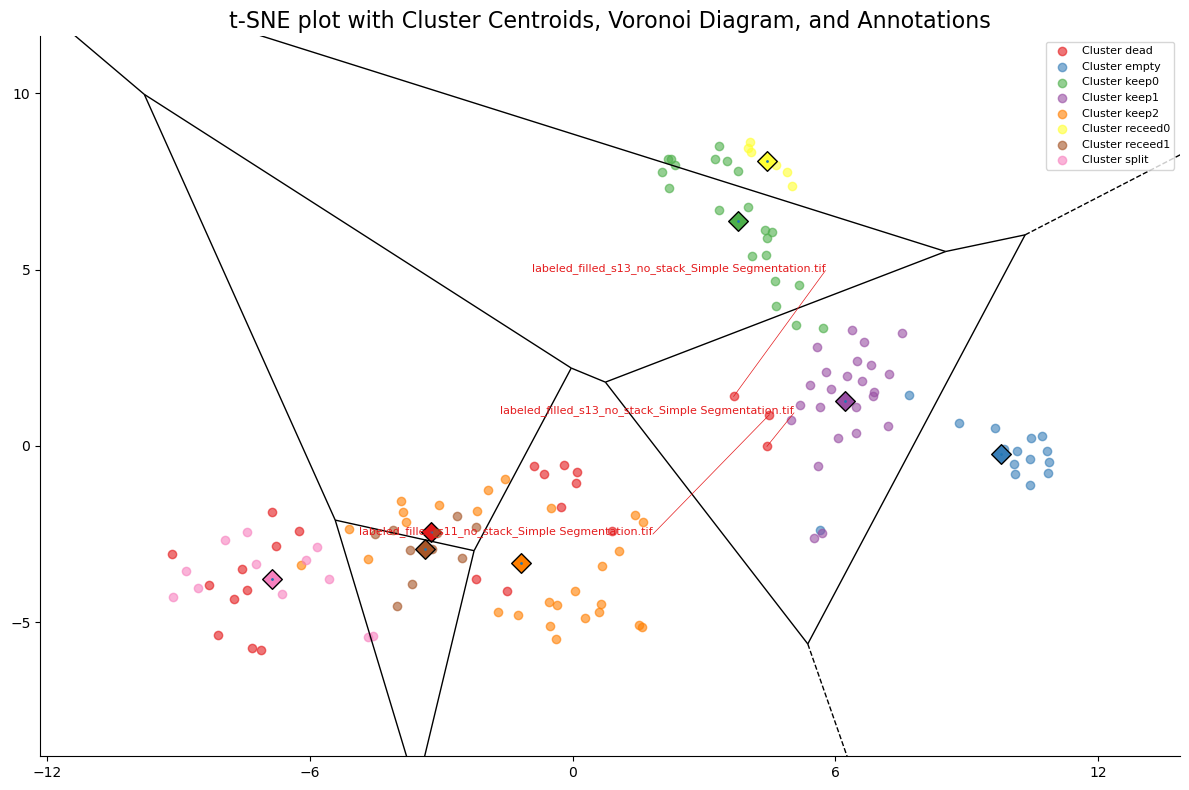

In [24]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + "statistics_features_test.csv")

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' column as it's not needed for t-SNE
features = data.drop('image_name', axis=1)

# Saving the labels for later use in the plot
labels = features['label']

data = features.copy()

# Dropping the 'label' column to scale only numerical features
features = features.drop('label', axis=1)

features = features[top_10_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Now let's perform t-SNE on the scaled features
tsne = TSNE(n_components=2, random_state=0)  # using 2 components for a 2D plot
# The fit might take a long time, depending on the size of your dataset
tsne_results = tsne.fit_transform(features_scaled)

unique_labels = np.unique(labels)
centroids = np.array([tsne_results[labels == label].mean(axis=0) for label in unique_labels])

vor = Voronoi(centroids)

# Start plot design enhancements here
fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size

# Step 4: Plot the t-SNE points and centroids
palette = plt.cm.Set1  # A nicer color map

for i, label in enumerate(unique_labels):
    points = tsne_results[labels == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)  # Diamond-shaped centroids

# Step 5: Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 7  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(tsne_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)

    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('t-SNE plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
# Set axis limits to the range of t-SNE results to avoid excessive whitespace
x_min, x_max = tsne_results[:, 0].min() - 3, tsne_results[:, 0].max() + 3
y_min, y_max = tsne_results[:, 1].min() - 3, tsne_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()


Successfully loaded data from E:/data_for_seg/


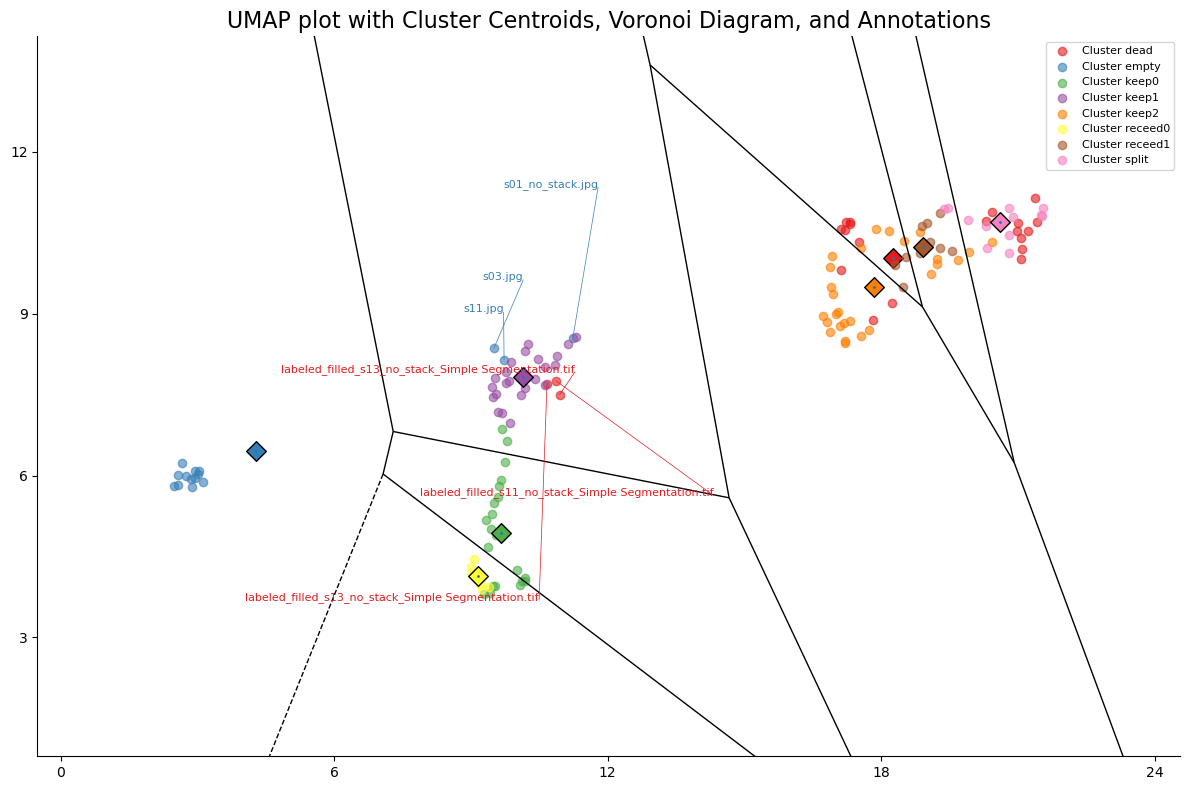

In [22]:
# Load data from a CSV file
data = pd.read_csv(get_hard_disk_path("Segmentation") + "statistics_features_test.csv")

# Save image names for later use in annotation
image_names = data['image_name']

# Dropping the 'image_name' and 'label' column
features = data.drop(['image_name', 'label'], axis=1)

# Select only top 10 features
features = features[top_10_feature_names]

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply UMAP
umap_results = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit_transform(features_scaled)

# Calculate centroids
unique_labels = np.unique(data['label'])
centroids = np.array([umap_results[data['label'] == label].mean(axis=0) for label in unique_labels])

# Calculate Voronoi
vor = Voronoi(centroids)

# Plot design
fig, ax = plt.subplots(figsize=(12, 8))

# Plot UMAP points and centroids
palette = plt.cm.Set1

for i, label in enumerate(unique_labels):
    points = umap_results[data['label'] == label]
    centroid = centroids[i]
    color = palette(i)
    
    ax.scatter(points[:, 0], points[:, 1], color=color, alpha=0.6, label=f'Cluster {label}')
    ax.scatter(centroid[0], centroid[1], color=color, edgecolors='black', marker='D', s=100)

# Overlay Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_vertices=False, point_size=2)

# Create a mapping from label to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Define function to get random label positions
def get_label_pos(point, offset=4.07):
    # Randomly choose an offset direction
    dx, dy = random.uniform(-offset, offset), random.uniform(-offset, offset)
    return point + np.array([dx, dy])

# Annotate far away points with lines
threshold = 5  # Define a suitable threshold
for i, (point, name, label) in enumerate(zip(umap_results, image_names, data['label'])):
    centroid_index = label_to_index[label]
    centroid = centroids[centroid_index]
    distance = np.linalg.norm(point - centroid)

    if distance > threshold:
        # Get random label position
        label_pos = get_label_pos(point)

        # Get color for the cluster
        color = palette(centroid_index)

        # Draw a line from point to label with the same color as the cluster
        ax.plot([point[0], label_pos[0]], [point[1], label_pos[1]], color=color, linestyle='-', linewidth=0.5)

        # Place text at the random label position
        ax.text(label_pos[0], label_pos[1], name, fontsize=8, ha='right', color=color)

# Enhancements
ax.set_title('UMAP plot with Cluster Centroids, Voronoi Diagram, and Annotations', fontsize=16)
ax.legend(fontsize=8, loc='upper right')
x_min, x_max = umap_results[:, 0].min() - 3, umap_results[:, 0].max() + 3
y_min, y_max = umap_results[:, 1].min() - 3, umap_results[:, 1].max() + 3
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()
